In [1]:
# Cargo librerias
import pandas as pd
import numpy as np
import itertools
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import nbimporter

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def plotImp(model, X , name, num=25, lgb=False, ci=False):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    
    tamanio_vertical = (num)/(2*1.2)

    plt.figure(figsize=(18, tamanio_vertical))
    
    #sns.set(font_scale = 3)
    rot = [-.75, -.5, -.25, 0, .25, .5, .75]
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
                palette=sns.cubehelix_palette(num, start=0, rot=random.choice(rot), reverse=True))
    
    titulo = name+" Top Feature Importances"
    if ci:
        titulo+= " (post Cumulative Importance)"
    plt.title(titulo, fontsize=20)
    plt.xlabel("Importance", fontsize=18)
    plt.ylabel("Feature", fontsize=18)
    plt.tick_params(grid_alpha=0.5, labelsize=15)
   
    plt.tight_layout()
#    if not ci:
#        file = name.lower()+"_feature_importance.png"
#    else:
#        file = name.lower()+"_ci_feature_importance.png"
#    plt.savefig(file)
    plt.show()

In [3]:
def csv_to_df_standarized(doc_csv):
    df = pd.read_csv(doc_csv)
    df = df.drop(df.columns[0],axis=1)
    df = df.drop('id',axis=1)
    return df
train = csv_to_df_standarized('features/train/features_keywords_numerical.csv')
train

,target,text_contains_keyword,has_keyword,keywords_quantity,keywords_mean,keyword_is_hashtag,keyword_frequency
0,1,1,1,1,0.004525,1,0.227027
1,1,1,1,1,0.004525,0,0.237838
2,1,1,1,1,0.004525,0,0.210811
3,1,1,1,1,0.004525,0,0.210811
4,1,1,1,1,0.004525,0,0.237838
...,...,...,...,...,...,...,...
7608,1,1,1,1,0.004525,0,0.194595
7609,1,1,1,0,0.000000,0,0.237838
7610,1,1,1,1,0.004525,0,0.151351
7611,1,1,1,3,0.013575,0,0.410811


In [6]:
params = {'num_leaves': 33,
          'min_split_gain': 0.01,
          'max_depth': 12,
          'learning_rate': 0.1,
          'feature_fraction': 0.30000000000000004,
          'bagging_fraction': 0.8,
          #parametros no optimizados
          'boosting_type':'gbdt',
          'objective':'binary',
          'metric':'accuracy',
}
n_estimators=85

In [7]:
X = train.drop((['target']), axis=1).values
Y = train['target'].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=50)

d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_val, label=Y_val)
watchlist = [d_valid]
reg = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=False)

In [ ]:
#No funciona por ahora
#Y_pred = reg.predict(X_val)
#print(accuracy_score(Y_pred,Y_val))

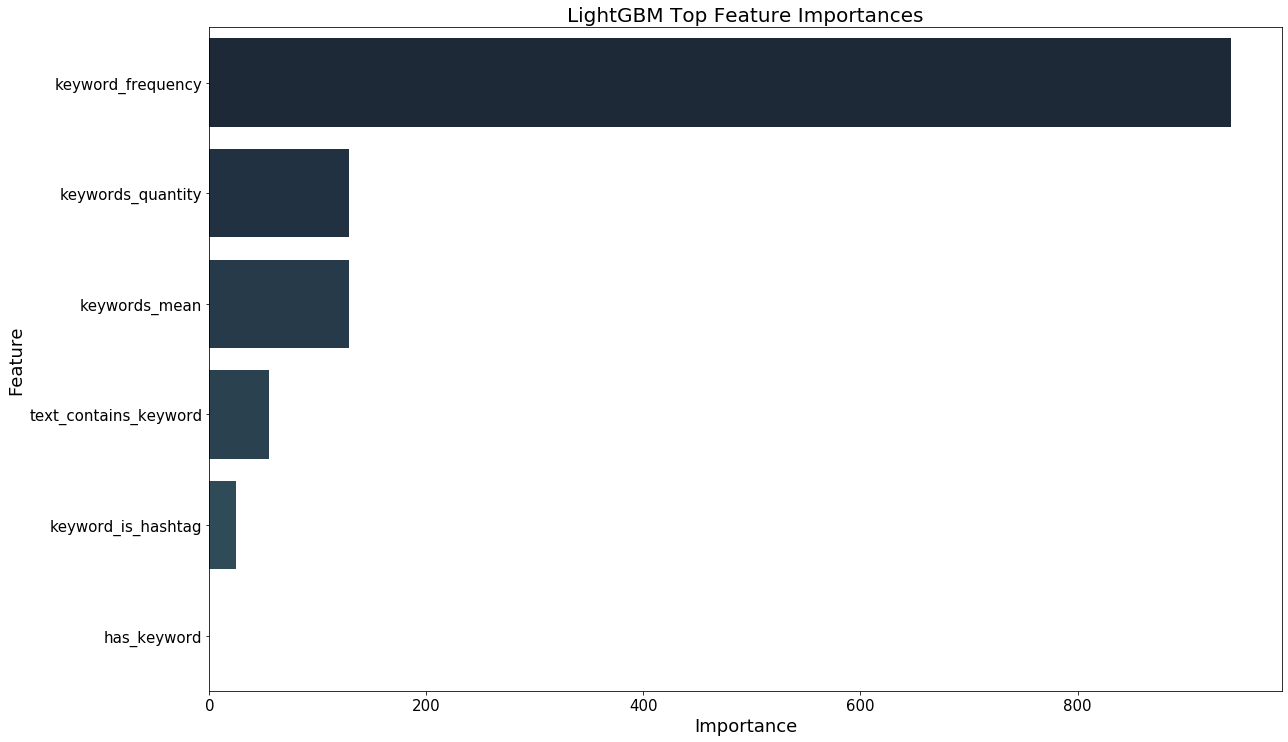

In [8]:
plotImp(reg, train.drop((['target']), axis=1), 'LightGBM', 25, lgb=True)